In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from google.colab import drive

In [ ]:
dataset, dataset_info = tfds.load("malaria", with_info = True, split = ['train'], shuffle_files = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [3]:
dataset

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpfvx4olgltfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_ds = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_ds = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_ds = val_test_ds.take(int(VAL_RATIO * DATASET_SIZE))
  test_ds = val_test_ds.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_ds, val_ds, test_ds

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
train_ds, val_ds, test_ds = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [7]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

22046
2755
2757


# Data visualisation

In [8]:
def get_label_str(label):
  if label == 0:
    return "Uninfected"
  else:
    return "Infected"

1
0
0
1
0
1
0
1
1
1
0
0
0
1
1
0


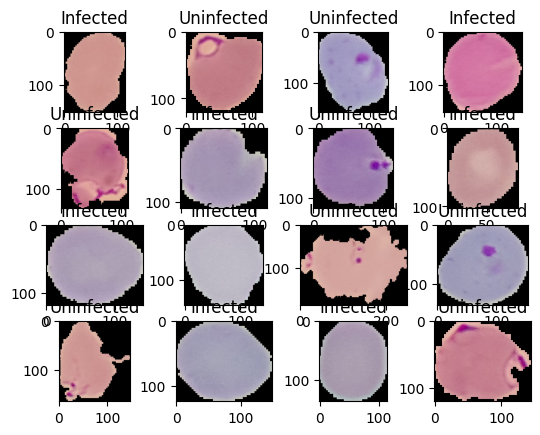

In [9]:
for i, sample in enumerate(train_ds.take(16)):
  ax = plt.subplot(4, 4, i+1)
  print(sample['label'].numpy())
  plt.imshow(sample['image'])
  plt.title(get_label_str(sample['label'].numpy()))

# Data processing (resizing and normalisation)

In [10]:
IM_SIZE = 224
BATCH_SIZE = 32 #creating batches to avoid input size mismatch while training

In [11]:
def resize_rescale(inputs):
  return tf.image.resize(inputs['image'], (IM_SIZE, IM_SIZE))/255.0, inputs['label']

In [12]:
train_dataset = train_ds.map(resize_rescale).shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(resize_rescale).shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(resize_rescale).shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [14]:
np.unique(image)

array([0.0000000e+00, 1.1721049e-05, 2.4972958e-05, ..., 9.2956269e-01,
       9.3221337e-01, 9.3645275e-01], dtype=float32)

# Building the model (ConvNet)

In [15]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3), name='image'),

    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'), #kernel size is the heightxwidth of the filter. Smaller size helps in locating local features. Larger in global
    BatchNormalization(), #normalises each batch for faster training
    MaxPool2D(pool_size = 2, strides = 2), #reduces spatial dimensions of the input volume

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(units = 100, activation = 'relu'),
    BatchNormalization(),
    Dense(units = 10, activation = 'relu'),
    BatchNormalization(),
    Dense(units = 1, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [16]:
model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = BinaryAccuracy()
)

In [17]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 100,
    verbose = 1
)

Epoch 1/100
689/689 [==============================] - 65s 81ms/step - loss: 0.3449 - binary_accuracy: 0.8541 - val_loss: 0.3987 - val_binary_accuracy: 0.9031
Epoch 2/100
689/689 [==============================] - 42s 61ms/step - loss: 0.2131 - binary_accuracy: 0.9260 - val_loss: 0.3051 - val_binary_accuracy: 0.9078
Epoch 3/100
689/689 [==============================] - 42s 61ms/step - loss: 0.2091 - binary_accuracy: 0.9301 - val_loss: 0.3468 - val_binary_accuracy: 0.8897
Epoch 4/100
689/689 [==============================] - 42s 61ms/step - loss: 0.4499 - binary_accuracy: 0.7557 - val_loss: 0.7143 - val_binary_accuracy: 0.5637
Epoch 5/100
689/689 [==============================] - 42s 61ms/step - loss: 0.6526 - binary_accuracy: 0.6148 - val_loss: 0.7788 - val_binary_accuracy: 0.5760
Epoch 6/100
689/689 [==============================] - 43s 63ms/step - loss: 0.6464 - binary_accuracy: 0.6217 - val_loss: 0.6994 - val_binary_accuracy: 0.5789
Epoch 7/100
689/689 [=========================

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if x<0.5:
    return str("Not infected")
  else:
    return str("Infected")

In [ ]:
print(parasite_or_not(model.predict(test_dataset.take(1))[0][0]))

In [ ]:
for image, label in test_dataset.take(1):
  for i in range (9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(image[i])
    plt.title(parasite_or_not(label.numpy()[i])+"-"+parasite_or_not(model.predict(image)[i][0]))
    plt.axis('off')

# Loading and Saving

Saving the model

In [ ]:
model.save("lenet")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()

In [ ]:
model.save("lenet.hdf5")

Saving just the weights

In [ ]:
model.save_weights("weights/lenet_weights")

In [ ]:
lenet_weights_model = model.load_weights("weights/lenet_weights")

In [ ]:
#to check if the model is running, just run the block where model is built, then compile and then directly evaluate
#no need for training again as the model has been saved and just running the lenet_loaded_model initialises it

#Saving to google drive

In [ ]:
drive.mount("/content/drive/")

In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/ #copying the trained lenet model to drive

In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/ #copying the trained lenet model from drive to colab when running the model again